The goal of this notebook is to find how and if popularity is related to any feature of a song

We first load the preprocessed notebook resulting from the first notebook

In [13]:
!pip -q install pyspark

from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql import SparkSession, functions as F, types as T

spark = SparkSession.builder.appName("FeatureImportance").getOrCreate()
#let's load the preprocessed DS created in notebook 2
SILVER = "file:///content/drive/MyDrive/data/spotify/silver_parquet"

df = spark.read.parquet(SILVER)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Here we print the genres

In [14]:
df.select("track_genre") \
  .where("track_genre IS NOT NULL") \
  .distinct() \
  .orderBy("track_genre") \
  .show(999, truncate=False)  # increase 999 if needed


+-----------------+
|track_genre      |
+-----------------+
|acoustic         |
|afrobeat         |
|alt-rock         |
|alternative      |
|ambient          |
|anime            |
|black-metal      |
|bluegrass        |
|blues            |
|brazil           |
|breakbeat        |
|british          |
|cantopop         |
|chicago-house    |
|children         |
|chill            |
|classical        |
|club             |
|comedy           |
|country          |
|dance            |
|dancehall        |
|death-metal      |
|deep-house       |
|detroit-techno   |
|disco            |
|disney           |
|drum-and-bass    |
|dub              |
|dubstep          |
|edm              |
|electro          |
|electronic       |
|emo              |
|folk             |
|forro            |
|french           |
|funk             |
|garage           |
|german           |
|gospel           |
|goth             |
|grindcore        |
|groove           |
|grunge           |
|guitar           |
|happy            |


The first method we use to measure which features are more related to popularity is Pearson correlation, that measures linear correlation.

In [15]:
from pyspark.sql.functions import corr

# features list = normalized + genre
features = [
    "duration_ms", "danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness", "valence", "tempo",
]

target = "popularity"

# compute Pearson correlations
for f in features:
      val = df.select(corr(f, target).alias("pearson")).first()["pearson"]
      print(f"{f}: {val}")


duration_ms: -0.026133590373498748
danceability: 0.06441783681073995
energy: 0.010517422990191996
loudness: 0.07181346617003292
speechiness: -0.05764466206947346
acousticness: -0.03398465375724745
instrumentalness: -0.14280024447061582
liveness: -0.003702257055405736
valence: -0.01055307618235016
tempo: 0.005504772230825541


From the results, we can see how musical features are basically non linearly realted to popularity (all values close to 0).


Let's now see what is the most popular genre

In [16]:
df.groupBy("track_genre") \
  .agg(F.avg("popularity").alias("avg_popularity")) \
  .orderBy(F.desc("avg_popularity")) \
  .show(20, truncate=False)


+-----------------+------------------+
|track_genre      |avg_popularity    |
+-----------------+------------------+
|pop-film         |60.43849938499385 |
|k-pop            |59.536026200873366|
|metal            |57.510822510822514|
|chill            |55.79209979209979 |
|latino           |51.78894472361809 |
|sad              |51.72679509632224 |
|grunge           |50.69257540603248 |
|indian           |50.43715846994535 |
|progressive-house|50.34675141242938 |
|anime            |49.07688442211055 |
|emo              |48.61129032258064 |
|sertanejo        |47.823244552058114|
|deep-house       |47.58410732714138 |
|piano            |47.22911392405063 |
|reggaeton        |47.21052631578947 |
|hard-rock        |45.99716312056738 |
|ambient          |45.80360721442886 |
|brazil           |45.75613660618997 |
|pagode           |45.57810650887574 |
|mandopop         |45.33256880733945 |
+-----------------+------------------+
only showing top 20 rows



So pop music on average produces the most popular songs.

Let's now train a regressor with lasso and see which are the biggest weights: in this phase we consider only musical features without the genre.

In [17]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

features_z = [
    "duration_ms_z","danceability_z","energy_z","loudness_z","speechiness_z",
    "acousticness_z","instrumentalness_z","liveness_z","valence_z","tempo_z"
]
target = "popularity"

data_z = VectorAssembler(inputCols=features_z, outputCol="features") \
           .transform(df.select(*features_z, target).dropna()) \
           .select("features", target)

train, test = data_z.randomSplit([0.8, 0.2], seed=42)

lasso = LinearRegression(
    featuresCol="features", labelCol=target,
    elasticNetParam=1.0, regParam=0.1,  # try 0.1; adjust if needed
    standardization=False               # already using *_z
)
model = lasso.fit(train)

pred = model.transform(test)
rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse").evaluate(pred)
r2   = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2").evaluate(pred)
print(f"RMSE={rmse:.4f}  R2={r2:.4f}")

for name, coef in zip(features_z, model.coefficients.toArray()):
    print(f"{name}: {coef:.6f}")
print("Intercept:", model.intercept)


RMSE=19.7017  R2=0.0351
duration_ms_z: -0.323973
danceability_z: 1.752434
energy_z: 0.000000
loudness_z: 0.063580
speechiness_z: -1.497382
acousticness_z: -0.184734
instrumentalness_z: -3.158445
liveness_z: 0.140284
valence_z: -2.102659
tempo_z: 0.000000
Intercept: 32.98485153172252


Also in this case, all the weights are close to zero, showing that popularity is not particularly correlated to any musical feature of songs.

We now add the genre. To do it we first have to one hot encode all the genre and see how every genre is related to popularity.

In [18]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# ---- features: normalized numeric + genre
features_z = [
    "duration_ms_z","danceability_z","energy_z","loudness_z","speechiness_z",
    "acousticness_z","instrumentalness_z","liveness_z","valence_z","tempo_z"
]
target = "popularity"

# ---- stages
indexer = StringIndexer(inputCol="track_genre", outputCol="genre_idx", handleInvalid="keep")
encoder = OneHotEncoder(inputCols=["genre_idx"], outputCols=["genre_oh"], handleInvalid="keep")
assembler = VectorAssembler(inputCols=features_z + ["genre_oh"], outputCol="features")

# ---- Lasso regressor
lasso = LinearRegression(
    featuresCol="features", labelCol=target,
    elasticNetParam=1.0, regParam=0.1,  # 1.0 = Lasso
    standardization=False               # features_z already normalized
)

# ---- pipeline
pipe = Pipeline(stages=[indexer, encoder, assembler, lasso])

# ---- train/test split
train, test = df.select(*features_z, "track_genre", target).dropna().randomSplit([0.8,0.2], seed=42)

model = pipe.fit(train)
pred = model.transform(test)

# ---- evaluation
rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse").evaluate(pred)
r2   = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2").evaluate(pred)
print(f"RMSE={rmse:.4f}  R2={r2:.4f}")


RMSE=17.4576  R2=0.2425


In [19]:
# After fitting the pipeline as shown earlier:
stages = model.stages  # indexer, encoder, assembler, lasso
lasso_model = stages[-1]   # last stage is the LinearRegressionModel
indexer_model = stages[0]  # first stage is the StringIndexerModel

# Numeric features
numeric_coefs = list(zip(features_z, lasso_model.coefficients.toArray()[:len(features_z)]))

# Genre dummies (names come from StringIndexer labels)
genre_labels = indexer_model.labels  # list of genres in order
genre_coefs = list(zip(genre_labels, lasso_model.coefficients.toArray()[len(features_z):]))

# Print nicely
print("=== Numeric feature coefficients ===")
for name, coef in numeric_coefs:
    print(f"{name}: {coef:.6f}")

print("\n=== Genre coefficients (one-hot dummies) ===")
for name, coef in genre_coefs:
    print(f"{name}: {coef:.6f}")

print("\nIntercept:", lasso_model.intercept)


=== Numeric feature coefficients ===
duration_ms_z: -0.115443
danceability_z: 1.537769
energy_z: -0.000444
loudness_z: 0.000000
speechiness_z: -1.402478
acousticness_z: -0.047980
instrumentalness_z: -2.544774
liveness_z: 0.000000
valence_z: -1.729704
tempo_z: 0.000000

=== Genre coefficients (one-hot dummies) ===
disney: 0.000000
grindcore: -6.352251
kids: -12.149089
club: 0.000000
heavy-metal: -0.394409
anime: 7.098520
study: 0.000000
children: 0.000000
j-idol: -1.784057
cantopop: 0.000000
happy: -3.826150
acoustic: 0.000000
afrobeat: 0.000000
honky-tonk: -10.998819
ambient: 6.173441
black-metal: -1.571464
breakbeat: -5.253905
new-age: 0.000000
tango: -4.874919
alt-rock: 0.000000
chicago-house: -11.909741
malay: 0.000000
salsa: 0.000000
sleep: 0.000000
comedy: 0.000000
idm: -7.725719
drum-and-bass: 0.000000
iranian: -19.117606
spanish: 0.000000
forro: 0.000000
bluegrass: -0.020148
chill: 10.445653
deep-house: 2.724876
dancehall: 0.000000
detroit-techno: -11.515952
emo: 3.090889
blues:

We can notice that some genre impact more than other on the popularity of the song, both positively and negatively: for example kpop has a weight of +15, while jazz of -16

Now we fit a random forest and measure the feature importance as last method to find a pattern between popularity and genre.

In [20]:
# ========= ROBUST RANDOM FOREST (drop-in) =========
# Uses your same RF pipeline/params; only ensures Spark/df are usable.

from pyspark.sql import SparkSession

# 1) Ensure Spark is alive; start fresh only if needed (no change if it's already running)
try:
    spark.range(1).count()
except Exception:
    try:
        spark.stop()
    except Exception:
        pass
    spark = (SparkSession.builder
             .appName("spotify-feature-importance-rf")
             .master("local[*]")
             .config("spark.ui.showConsoleProgress", "false")
             .config("spark.driver.bindAddress", "127.0.0.1")
             .config("spark.driver.host", "127.0.0.1")
             .config("spark.driver.memory", "6g")        # bump if needed
             .config("spark.sql.shuffle.partitions", "64")
             .getOrCreate())

# 2) Make sure df is valid for THIS session; otherwise re-read just the needed columns
READ_PATH = "file:///content/drive/MyDrive/data/spotify/silver_parquet"  # adjust if your path differs
need_cols = [
    "track_genre","popularity",
    "duration_ms_z","danceability_z","energy_z","loudness_z","speechiness_z",
    "acousticness_z","instrumentalness_z","liveness_z","valence_z","tempo_z"
]
try:
    _ = df.select(*need_cols).limit(1).count()
except Exception:
    df = (spark.read.parquet(READ_PATH)
          .select(*need_cols)
          .dropna())

# 3) Features/target (reuse if already defined; otherwise define)
try:
    features_z
except NameError:
    features_z = [
        "duration_ms_z","danceability_z","energy_z","loudness_z","speechiness_z",
        "acousticness_z","instrumentalness_z","liveness_z","valence_z","tempo_z"
    ]
target = "popularity"

# 4) Pipeline: index → one-hot → assemble → RF (same params you used)
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

idx = StringIndexer(inputCol="track_genre", outputCol="genre_idx", handleInvalid="keep")
encoder = OneHotEncoder(inputCols=["genre_idx"], outputCols=["genre_oh"], handleInvalid="keep")
assembler = VectorAssembler(inputCols=features_z + ["genre_oh"], outputCol="features")

# Define the RandomForestRegressor - you can adjust these parameters
rf = RandomForestRegressor(featuresCol="features", labelCol=target, numTrees=100, maxDepth=10, seed=42)

# Create the pipeline
rf_pipeline = Pipeline(stages=[idx, encoder, assembler, rf])

# Split data
train, test = df.randomSplit([0.8, 0.2], seed=42)

# Fit the model
rf_model = rf_pipeline.fit(train)

# Make predictions
pred = rf_model.transform(test)

# Evaluate the model
rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse").evaluate(pred)
r2   = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2").evaluate(pred)
print(f"Random Forest RMSE={rmse:.4f}  R2={r2:.4f}")

Random Forest RMSE=17.3303  R2=0.2445


And finally we plot the results.

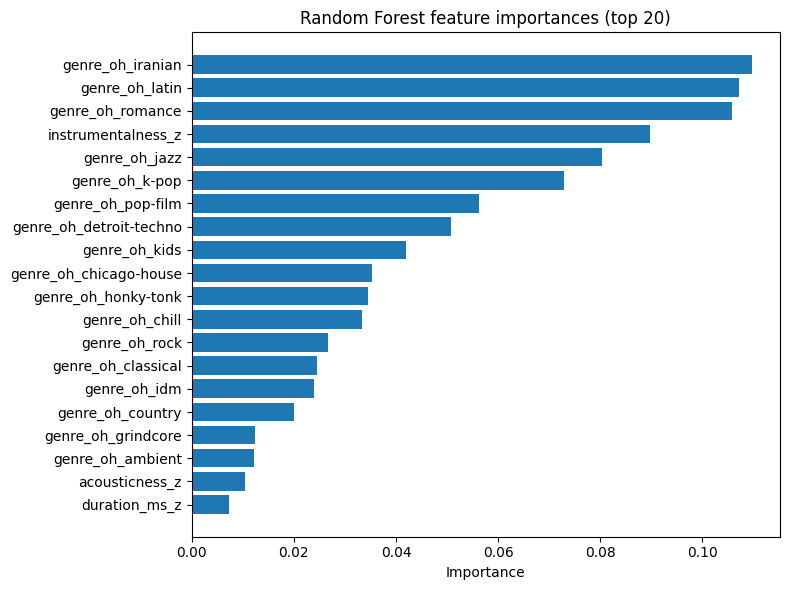

In [21]:
# Map RF importances back to names and plot
import pandas as pd
import matplotlib.pyplot as plt

rf_stage = rf_model.stages[-1]      # RandomForestRegressionModel
assembler_model = rf_model.stages[-2] # Get the VectorAssembler model stage
encoder_model = rf_model.stages[-3] # Get the OneHotEncoder model stage
indexer_model = rf_model.stages[-4] # Get the StringIndexer model stage


importances = rf_stage.featureImportances.toArray()

# Apply the stages up to the assembler to a small sample of the training data
# to get the schema with the assembled features and their metadata.
temp_df = indexer_model.transform(train.limit(1))
temp_df = encoder_model.transform(temp_df)
assembled_temp_df = assembler_model.transform(temp_df)

# Get the feature names directly from the metadata of the assembled vector column
assembled_train_schema = assembled_temp_df.schema["features"]
feature_names = [f['name'] for f in assembled_train_schema.metadata["ml_attr"]["attrs"]["numeric"] +
                 assembled_train_schema.metadata["ml_attr"]["attrs"]["binary"]]


imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
imp_df = imp_values = imp_df.sort_values("importance", ascending=True)

# Plot top 20 by importance
top_imp = imp_df.tail(20)

plt.figure(figsize=(8, 6))
plt.barh(top_imp["feature"], top_imp["importance"])
plt.title("Random Forest feature importances (top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# (Optional) print full ranking
# display(imp_df.sort_values("importance", ascending=False))